U-net is a popular CNN architecture commonly used for tasks related to image segmentation (dividing an image into subgroups such as objects or regions, like Photoshop auto-select feature, also precise localization is to identify and delineate the boundaries of objects within an image)

Examples include:


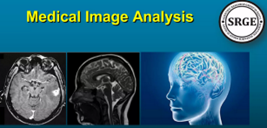
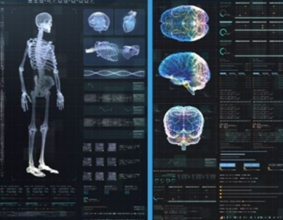
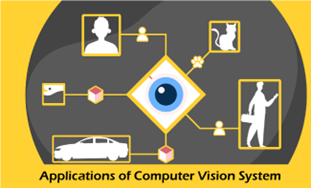

The U-net architecture is named after its U shape design, which resemble an encoder-decoder structure. The network has contracting path, known as encoder and expanding path, known as decoder.
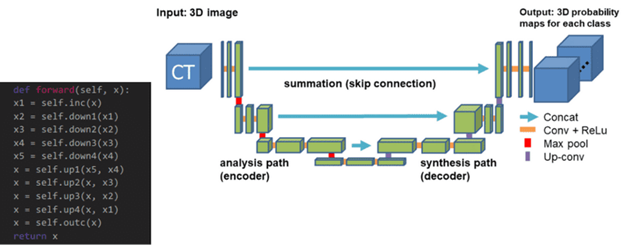

From what I understand, U-net is simply a CNN architecture that is mostly based on the two functions: down sampling first then up sampling. Basically, the down sampling thing is to use a picture based on its dimension then divide it into non-overlapping regions that has the highest values selected. On the other hand, up sampling would be the opposite, using the value from a pixel and then turn it into many ones for a whole region when the 1 pixel is multiplied into 4 etc. 
During running the codes, two concepts that I need to learn when running a neural network include:
-Batch size
-Buffer size
Also, it appears that the Unet is indeed an architecture of the image segmentation, as I didn’t fully grasp this aspect before. Because of this, within its concept, there are applications of different techniques in NN such as Convolutional layer, Max pool, up sampling, down sampling etc. Due to this, I’m going to try to understand the very basics of the above. 
Convolutional layer: It is a neural network layer which applies convolutional mathematical operation (use f and g functions to produce a third function f*g that express how the shape of one is modified by the other) to change its input. 
Relu: It is the activation function in NN. It introduces non-linearity to the network and help captures the complex pattern of the data. 
Max Pooling: it is the popular down sampling method explained above. It reduces the spatial dimension of the data. It divides the input into smaller regions and only keep the maximum values of each region, which discarding the rest. 

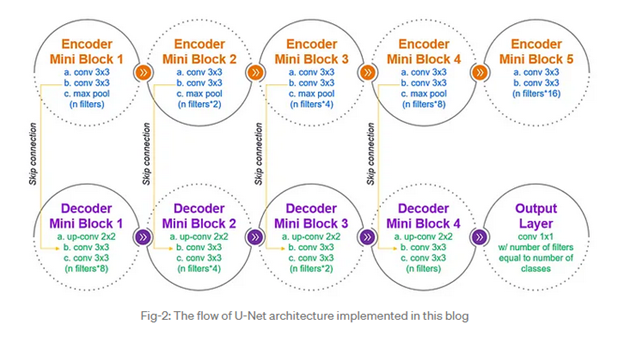

As an image segmentation tool, Unet is created so that it can automatically outlines different regions based on their pixels according to each identified class. While there were many predecessors, Unet stand out for its abilities to lessen computational expensive and minimize information loss. 
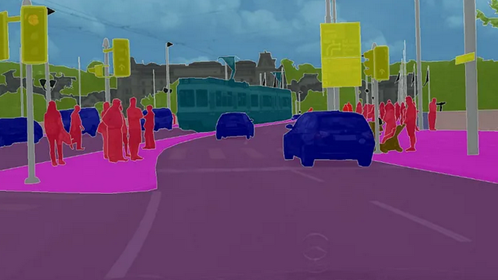

Apparently, my understanding of convolutional NN was quite limited and lacking yesterday, as the full and comprehended analyzes of it can be better demonstrated in this pic.
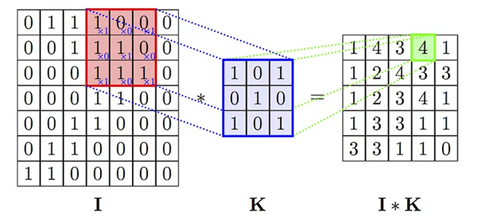

First take the filter matrix K, smaller than the input layer of I and then perform an element wise operation multiplication to create a single value of the output matrix.
Second step is to filter the columns on the right based on the defined stride and repeat step 1. 
It seems like the concat step I see yesterday can be also explained like this. Skip connections (copy and crop). This technique copies the image matrix from earlier layer and then use it as part of the later layer (LHS layer and RHS layer). This step is to preserve information from richer matrix and prevent information loss. 


In [ ]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np



dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


print(info)


#resize the image to a 128*128 height width size
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask


#augment the dataset by flipping them horizontally 
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)

   return input_image, input_mask

#normalize dataset by scaling the image within [-1,1], also decrease image mask by 1
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask



#create two functions to process train vs test sets with only difference is that 
# the train has flipping while test doesn't 
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask


#use Map function to create an input pipeline wiht data 
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)



#image vs image mask shape and datatype 
print(train_dataset)


#various setting tuners parameters that I yet to understand 
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)




def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])




#Started making the Unet architecture

#Create the enconder using convolution block 
def double_conv_block(x, n_filters):

   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

   return x


#down sample block
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)

   return f, p


#up sample block 
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)

   return x




def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(128, 128, 3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation="softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model



# Usage:
unet_model = build_unet_model()

unet_model.summary()


#plot model using keras ulti 

from tensorflow.keras.utils import plot_model

plot_model(unet_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)




#compile the model and use its specific settings 

unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")

NUM_EPOCHS = 20

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches)




#prediction 

def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]
def show_predictions(dataset=None, num=1):
 if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
 else:
   display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)

